In [2]:
import sys
sys.path.insert(0, './Trees')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import subprocess
from scipy.spatial.distance import *
from Utils_dendrograms_OPT import prune_dendro, from_cloud_to_dendro_sublvl
from top_TED_lineare_multiplicity import top_TED_lineare as TED
from copy import deepcopy

from Interleaving_distance import interleaving, interl_approx

In [3]:
from pool_fn import *

In [4]:
import skfda

from skfda.preprocessing.smoothing import KernelSmoother
from skfda.preprocessing.smoothing.validation import SmoothingParameterSearch

from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix
from skfda.datasets import fetch_growth, fetch_octane, fetch_nox, fetch_tecator, fetch_ucr
from scipy.interpolate import interp1d as spline
from scipy.interpolate import CubicSpline as Cspline


In [5]:
def smooth_data(DATA, b):

    smooth = []
    nw = skfda.preprocessing.smoothing.KernelSmoother(
    kernel_estimator=skfda.misc.hat_matrix.NadarayaWatsonHatMatrix(bandwidth=b))

    for fd in DATA:

        smooth.append(nw.fit_transform(fd))        
        
    return smooth

from numba import jit, int32, prange

@jit(nopython=True, fastmath=True)
def w(x):
    return (35/32)*(1-3*(x**2) + 3*(x**4) - x**6)*(np.abs(x)<=1)

@jit(nopython=True, fastmath=True)
def w_1(x):
    return (35/32)*(-6*x + 12*(x**3) - 6*(x**5))*(np.abs(x)<=1)

@jit(nopython=True, fastmath=True)
def w_2(x):
    return (35/32)*(-6 + 36*(x**2) - 30*(x**4))*(np.abs(x)<=1)


@jit(nopython=True, fastmath=True)
def smooth_numba(f,x,grid,h):
    
    out_1 = np.zeros_like(grid)
    out_2 = np.zeros_like(grid)
    n = len(x)
    
    for i in range(n):
        x_i = x[i]
        y_i = f[i]
        tmp = (grid-x_i)/h
        
        out_1+= w(tmp)*y_i
        out_2+= w(tmp)
    
    return out_1/out_2

In [18]:
from sklearn.cluster import  DBSCAN, OPTICS
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis   
from sklearn.metrics import confusion_matrix
from sklearn.manifold import Isomap, MDS, LocallyLinearEmbedding
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression


def classify(X,labels):
    
    classes = np.unique(labels)
    N = len(labels)
    n_class= len(classes)

    MAT = np.zeros((n_class,n_class))

    for n in np.arange(2,np.min([len(labels)//2,50]),2):
        for neigh in np.arange(5,len(labels)-1,np.max([3,len(labels)//50])):
            
            print('n=',n,'; neigh=',neigh,'     ',end='\r')
            
            feat=deepcopy(X)
            red_algorithm=Isomap(n_components=n,n_neighbors=neigh).fit(feat)
            feat = red_algorithm.transform(feat)
            err = []
            for alg, clf in enumerate([QuadraticDiscriminantAnalysis(tol=1.0e-10)]):
                matrix=np.zeros((n_class,n_class))

                for test_ in range(N):

                    train=np.c_[feat[:,:test_],feat[:,(test_+1):]]        
                    test=[train[test_,:]]
                    train=np.r_[train[:test_,:],train[(test_+1):,:]]            

                    test=np.asarray(test)

                    gr_truth=np.copy(labels)

                    test_truth=[gr_truth[test_]]
                    tr_truth=np.r_[gr_truth[:test_],gr_truth[(test_+1):]]
                    test_truth=np.asarray(test_truth)

                    tr_red=train
                    test_red=test

                    clf.fit(tr_red, tr_truth)
                    labels_=clf.predict(test_red)

                    if not labels_ == test_truth:
                        err.append(test_)

                    cnf_matrix = confusion_matrix(test_truth,labels_,labels=classes)
                    matrix = matrix+cnf_matrix

                if sum(np.diag(matrix))>sum(np.diag(MAT)):
                    MAT=matrix
                    ENNE=n
                    NEIGH = neigh
                    ERR = err
                        
    return MAT,ENNE,NEIGH,ERR   


def regression(X,y,p=2):
     
    pred = np.zeros_like(y)
    N = len(y)
    
    MSE = []
    
#    for n in np.arange(2,len(y)//2,np.max([1,len(y)//50])):
    for n in np.arange(10,len(y)//2,2):
#        for neigh in np.arange(5,len(y),np.max([1,len(y)//50])):
        for neigh in np.arange(50,len(y)-1,2):
            feat=deepcopy(X)
            red_algorithm=Isomap(n_components=n,n_neighbors=neigh).fit(feat)
            feat = red_algorithm.transform(feat)
            pred = np.zeros_like(y)
            
            print('n=',n,'; neigh=',neigh,'     ',end='\r')
            
            for test_ in range(N):    

                train=np.c_[feat[:,:test_],feat[:,(test_+1):]]        
                test=[train[test_,:]]
                train=np.r_[train[:test_,:],train[(test_+1):,:]]            

                test=np.asarray(test)

                gr_truth=np.copy(y)

                tr_truth=np.r_[gr_truth[:test_],gr_truth[(test_+1):]]

                tr_red=train
                test_red=test

                reg = LinearRegression().fit(train, tr_truth)

                pred[test_]=reg.predict(test_red)
                
            MSE.append(np.mean((np.abs(pred-y))**p))
            
            if len(MSE)==1:
                mse = MSE[0]
                ENNE=n
                NEIGH = neigh
            elif MSE[-1]<=mse:
                mse = MSE[-1]
                ENNE=n
                NEIGH = neigh

    return mse,ENNE,NEIGH,MSE  


def vanilla_class(X,labels):
    
    classes = np.unique(labels)
    N = len(labels)
    n_class= len(classes)

    MAT = np.zeros((n_class,n_class))

    feat=deepcopy(X)
    err = []
    for alg, clf in enumerate([QuadraticDiscriminantAnalysis(tol=1.0e-10)]):
        matrix=np.zeros((n_class,n_class))

        for test_ in range(N):

            train=np.c_[feat[:,:test_],feat[:,(test_+1):]]        
            test=[train[test_,:]]
            train=np.r_[train[:test_,:],train[(test_+1):,:]]            

            test=np.asarray(test)

            gr_truth=np.copy(labels)

            test_truth=[gr_truth[test_]]
            tr_truth=np.r_[gr_truth[:test_],gr_truth[(test_+1):]]
            test_truth=np.asarray(test_truth)

            tr_red=train
            test_red=test

            clf.fit(tr_red, tr_truth)
            labels_=clf.predict(test_red)

            if not labels_ == test_truth:
                err.append(test_)

            cnf_matrix = confusion_matrix(test_truth,labels_,labels=classes)
            matrix = matrix+cnf_matrix

        if sum(np.diag(matrix))>sum(np.diag(MAT)):
            MAT=matrix
            ERR = err
                        
    return MAT,ERR 


def vanilla_regression(X,y,p=2):
    
    pred = np.zeros_like(y)
    N = len(y)
    
    feat=deepcopy(X)
    pred = np.zeros_like(y)

    for test_ in range(N):    

        train=np.c_[feat[:,:test_],feat[:,(test_+1):]]        
        test=[train[test_,:]]
        train=np.r_[train[:test_,:],train[(test_+1):,:]]            

        test=np.asarray(test)

        gr_truth=np.copy(y)

        tr_truth=np.r_[gr_truth[:test_],gr_truth[(test_+1):]]

        tr_red=train
        test_red=test

        reg = LinearRegression().fit(train, tr_truth)

        pred[test_]=reg.predict(test_red)

    mse=np.mean((np.abs(pred-y))**p)

    return mse

def rsquared(y_true, y_pred):
    
    # Obtaining the mean of actual values
    mean_ytrue = sum(y_true) / len(y_true)
    
    # Obtaining the sum of the squared differences between actual and predicted values
    sum_of_squared_residuals = 0
    for true, predicted in zip (y_true, y_pred):
        sum_of_squared_residuals += (true - predicted) ** 2
    
    # Obtaining the total sum of squares
    total_sum_of_squares = 0
    for true in y_true:
        total_sum_of_squares += (true - mean_ytrue) ** 2
        
    # Computing the R-Squared score
    r_squared_score = 1 - (sum_of_squared_residuals / total_sum_of_squares)
        
    return r_squared_score

In [9]:
dataset = fetch_ucr('Beef')

data = dataset['data']
labels = dataset['target']

labels = labels-np.min(labels)

In [11]:
print(len(data),data[0].data_matrix[0].shape,data[0].grid_points[0].shape,np.unique(labels))

60 (470, 1) (470,) [0 1 2 3 4]


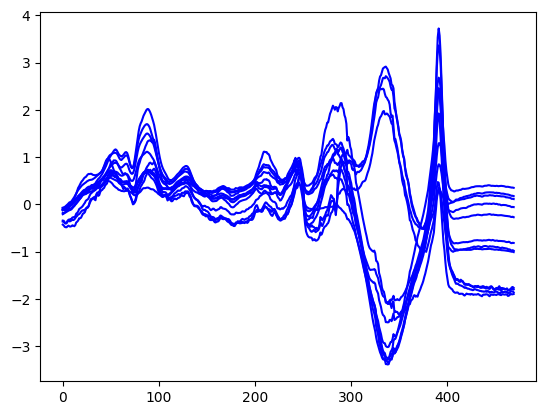

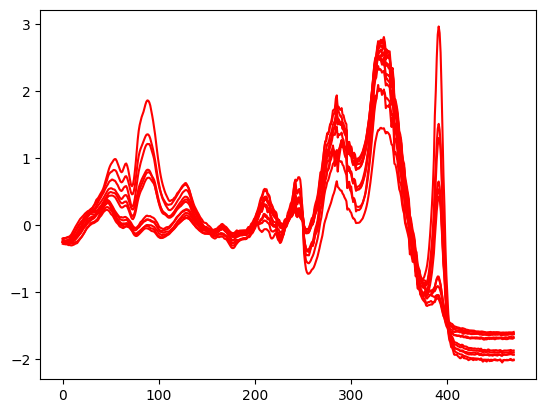

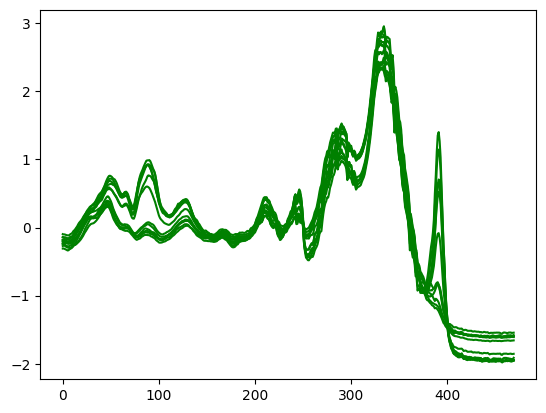

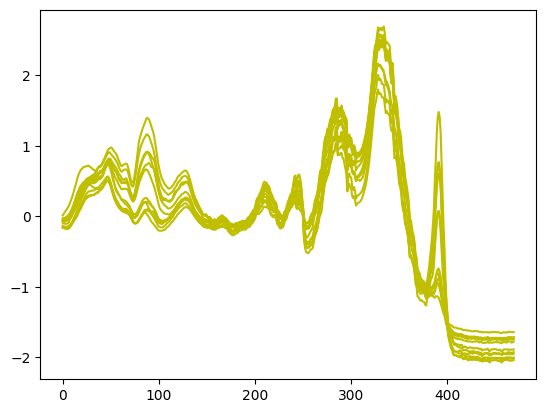

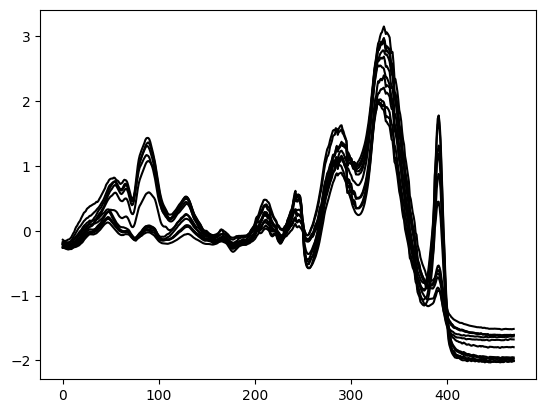

4
3
2
1
0


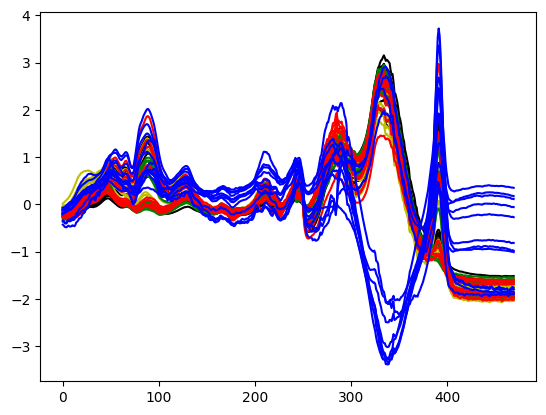

In [12]:
colors = ['b','r','g','y','k','c','m']

 
FUN = []
GRID = []
labels_ = []

norm = False

if 
    
    
for i,fd in enumerate(data):

    f = fd.data_matrix[0][:,0].reshape(len(fd.data_matrix[0]))
    x = fd.grid_points[0]
    l = labels[i]
    
    if norm:
        
        f = f + np.min(f)
        
        dx = np.diff(x)
        
    
    if not np.isnan(np.min(f)):
        FUN.append(f)
        GRID.append(x)
        labels_.append(l)
    
    
labels = np.array(labels_)
    
for k in np.unique(labels):
    for j,f in enumerate(FUN):
        
        if k == labels[j]:

            grid=GRID[j]
            plt.plot(grid,f,c=colors[labels[j]])
    plt.show()
    
    
for k in np.unique(labels)[::-1]:
    print(k)
    for j,f in enumerate(FUN):
        
        if k == labels[j]:
            grid=GRID[j]
            plt.plot(grid,f,c=colors[labels[j]])


In [33]:
Norm=np.zeros((len(FUN),len(FUN)))

for z in range(len(FUN)):
    for j in range(len(FUN)):
        if j<z:
            Norm[z,j] = np.max(np.abs(FUN[z]-FUN[j]))

Norm=Norm+Norm.T    

np.save('./Dataset_Matrices/Norm_Beef',Norm)

In [32]:
TREES = []
LEN = []

for j,f in enumerate(FUN):

    print(j,end='\r')

    D=np.arange(len(f))

    T = from_cloud_to_dendro_sublvl(D,f,1.01, None,\
                                    prec = 0.0000001, prune_param = None, ITris=[])

    T.make_mult(f=False)

    TREES.append(T)

LEN.append(np.sort([len(t.leaves) for t in TREES])[::-1])

print(LEN)

Non iniettiva:  464 470
Ora è iniettiva:  470 470
Non iniettiva:  465 470
Ora è iniettiva:  470 470


KeyboardInterrupt: 

In [21]:
np.sort([len(t.leaves) for t in TREES])[::-1]

array([64, 60, 59, 56, 55, 55, 54, 53, 52, 51, 51, 50, 50, 48, 48, 48, 48,
       48, 47, 47, 46, 46, 45, 45, 45, 44, 44, 44, 43, 43, 43, 42, 42, 42,
       41, 41, 41, 40, 39, 38, 37, 37, 37, 37, 37, 36, 36, 36, 36, 35, 35,
       34, 34, 33, 33, 33, 33, 33, 32, 30])

In [22]:
def prune_tree(T,max_leaves=15,N=100, return_eps = True):
    
    grid = np.linspace(0,1,N)
    eps = (1-grid)**6
    
    if len(T.leaves)<max_leaves:
        eps = [0]
    else:
        M = T.f_uniq[-1]-T.f_uniq[0]
        eps = eps*M
        
    thresh = eps[0]
    d = 0
    cnt = -1
    
    T_aux = prune_dendro(T,thresh,keep_root=False)
    
    tmp_T = 0
    
    while cnt+1<len(eps) and len(T_aux.leaves)<max_leaves:
        cnt+=1
        thresh = eps[cnt] 
        
        T_aux = prune_dendro(T,thresh,keep_root=False)

    idx = cnt-1
    thresh = eps[idx]
    T_aux = prune_dendro(T,thresh,keep_root=False)

    if return_eps:
        return [T_aux,thresh]
    else:
        return T_aux

In [23]:
TREES_approx = []

for T in TREES:
    TREES_approx.append(prune_tree(T,max_leaves=15,N=100))
    print(len(TREES_approx))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [30]:
np.sort([len(t[0].leaves) for t in TREES_approx])[::-1]

array([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 12, 12])

In [24]:
D=np.zeros((len(TREES_approx),len(TREES_approx)))

for z in range(len(TREES_approx)):

    print('Doing Line: ',z)

    for j in range(len(TREES_approx)):
        if j<z:
            
            d_aux = interleaving(TREES_approx[z][0], TREES_approx[j][0], binary=True,approx='up', 
                                          MP=True, check=False,
                                          verbose = False)
            
            D[z,j] = np.max([d_aux,TREES_approx[z][1], TREES_approx[j][1]])

D_I_up=D+D.T
np.save('./Dataset_Matrices/D_I_up_Beef',D_I_up)

Siamo alla riga:  0
Siamo alla riga:  1
Siamo alla riga:  2
Siamo alla riga:  3
Siamo alla riga:  4
Siamo alla riga:  5
Siamo alla riga:  6
Siamo alla riga:  7
Siamo alla riga:  8
Siamo alla riga:  9
Siamo alla riga:  10
Siamo alla riga:  11
Siamo alla riga:  12
Siamo alla riga:  13
Siamo alla riga:  14
Siamo alla riga:  15
Siamo alla riga:  16
Siamo alla riga:  17
Siamo alla riga:  18
Siamo alla riga:  19
Siamo alla riga:  20
Siamo alla riga:  21
Siamo alla riga:  22
Siamo alla riga:  23
Siamo alla riga:  24
Siamo alla riga:  25
Siamo alla riga:  26
Siamo alla riga:  27
Siamo alla riga:  28
Siamo alla riga:  29
Siamo alla riga:  30
Siamo alla riga:  31
Siamo alla riga:  32
Siamo alla riga:  33
Siamo alla riga:  34
Siamo alla riga:  35
Siamo alla riga:  36
Siamo alla riga:  37
Siamo alla riga:  38
Siamo alla riga:  39
Siamo alla riga:  40
Siamo alla riga:  41
Siamo alla riga:  42
Siamo alla riga:  43
Siamo alla riga:  44
Siamo alla riga:  45
Siamo alla riga:  46
Siamo alla riga:  47
Si

In [27]:
from sklearn.manifold import Isomap, MDS, LocallyLinearEmbedding

D_I = np.load('./Dataset_Matrices/D_I_up_Beef.npy')

res_PD = classify(D_I,labels)
acc_PD = np.sum(np.diag(res_PD[0]))/len(labels)

MAT_PD,ENNE_PD,NEIGH_PD,_ = res_PD

print('D_I Params: ',MAT_PD,ENNE_PD,NEIGH_PD)
print('Accuracy D_I: ',acc_PD)

D_I Params:  [[ 6.  0.  3.  2.  1.]
 [ 2.  6.  0.  3.  1.]
 [ 0.  0. 11.  1.  0.]
 [ 0.  0.  3.  9.  0.]
 [ 0.  0.  3.  0.  9.]] 12 38
Accuracy D_I:  0.6833333333333333


In [34]:
np.sum(D_I>Norm)

0

In [281]:
import persim
import ripser as rip

DGMS = []
MAX = -1

for datum in FUN:
    dgm = rip.lower_star_img(np.array([datum]))
    dgm = dgm[dgm[:,1]<999999999999]
    DGMS.append(dgm)

D=np.zeros((len(DGMS),len(DGMS)))
for i in range(len(DGMS)):

    print('Siamo alla riga: ',i)

    for j in range(len(DGMS)):
        if j<i:
            D[i,j] = persim.bottleneck(DGMS[i], DGMS[j], matching=False)

M=D+D.T


np.save('./Dataset_Matrices/PD_Beef.npy',M)

Siamo alla riga:  0
Siamo alla riga:  1
Siamo alla riga:  2
Siamo alla riga:  3
Siamo alla riga:  4
Siamo alla riga:  5
Siamo alla riga:  6
Siamo alla riga:  7
Siamo alla riga:  8
Siamo alla riga:  9
Siamo alla riga:  10
Siamo alla riga:  11
Siamo alla riga:  12
Siamo alla riga:  13
Siamo alla riga:  14
Siamo alla riga:  15
Siamo alla riga:  16
Siamo alla riga:  17
Siamo alla riga:  18
Siamo alla riga:  19
Siamo alla riga:  20
Siamo alla riga:  21
Siamo alla riga:  22
Siamo alla riga:  23
Siamo alla riga:  24
Siamo alla riga:  25
Siamo alla riga:  26
Siamo alla riga:  27
Siamo alla riga:  28
Siamo alla riga:  29
Siamo alla riga:  30
Siamo alla riga:  31
Siamo alla riga:  32
Siamo alla riga:  33
Siamo alla riga:  34
Siamo alla riga:  35
Siamo alla riga:  36
Siamo alla riga:  37
Siamo alla riga:  38
Siamo alla riga:  39
Siamo alla riga:  40
Siamo alla riga:  41
Siamo alla riga:  42
Siamo alla riga:  43
Siamo alla riga:  44
Siamo alla riga:  45
Siamo alla riga:  46
Siamo alla riga:  47
Si

In [16]:
from sklearn.manifold import Isomap, MDS, LocallyLinearEmbedding
import warnings
warnings.filterwarnings('ignore')

PD = np.load('./Dataset_Matrices/PD_Beef.npy')

res_PD = classify(PD,labels)
acc_PD = np.sum(np.diag(res_PD[0]))/len(labels)

MAT_PD,ENNE_PD,NEIGH_PD,_ = res_PD

print('PD Params: ',MAT_PD,ENNE_PD,NEIGH_PD)
print('Accuracy PD: ',acc_PD)

PD Params:  [[ 5.  0.  1.  5.  1.]
 [ 0.  5.  4.  1.  2.]
 [ 0.  0.  6.  0.  6.]
 [ 1.  0.  0.  9.  2.]
 [ 0.  0.  0.  2. 10.]] 12 17
Accuracy PD:  0.5833333333333334


In [19]:
FUN = np.array(FUN) 

print(FUN.shape)

for n_comp in np.arange(2,min(FUN.shape),2):

    pca = PCA(n_components=n_comp, svd_solver='full')
    X = pca.fit_transform(FUN)


    res_van = vanilla_class(X,labels)
    acc_van = np.sum(np.diag(res_van[0]))/len(labels)

    print('Accuracy',n_comp,acc_van)

(60, 470)
Accuracy 2 0.55
Accuracy 4 0.6333333333333333
Accuracy 6 0.65
Accuracy 8 0.7
Accuracy 10 0.5
Accuracy 12 0.38333333333333336
Accuracy 14 0.36666666666666664
Accuracy 16 0.5833333333333334
Accuracy 18 0.6
Accuracy 20 0.4166666666666667
Accuracy 22 0.5333333333333333
Accuracy 24 0.5
Accuracy 26 0.5166666666666667
Accuracy 28 0.5333333333333333
Accuracy 30 0.38333333333333336
Accuracy 32 0.5
Accuracy 34 0.55
Accuracy 36 0.5833333333333334
Accuracy 38 0.4666666666666667
Accuracy 40 0.45
Accuracy 42 0.5166666666666667
Accuracy 44 0.43333333333333335
Accuracy 46 0.6
Accuracy 48 0.4666666666666667
Accuracy 50 0.48333333333333334
Accuracy 52 0.5333333333333333
Accuracy 54 0.45
Accuracy 56 0.5
Accuracy 58 0.48333333333333334
